# Problem 1
Modify the classes AdalineGD and LogisticRegressionGD in the textbook such that the bias
data field b is absorbed by the weight vector w . Your program is required to be compatible with the training
programs in the textbook.

In [2]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
NUM_ITER = 500
ETA = 0.01

In [4]:
class AdalineGD(object):
    """
    Orginal Implementation taken from textbook
    ADApative LInear NEuron Classifier
    Params: 
    eta (float) : Learning rate (between 0.0 and 1.0)
    n_iter (int) : Number of passes over the training dataset.
    random_state (int) : Random number generator seed for random weight initialization.

    Attrs:
    w_ (1d-array) : Weights after fitting.
    cost_ (list) : Sum-of-squares cost function value in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Object
        """
        n = X.shape[0] #number of samples
        m = X.shape[1] #number of features 
        x_0 = np.ones((n,1)) 
        X = np.hstack((x_0,X)) #here we appended a column of 1's to X to make the dimensions match
                               #when doing the dot product with the weights when the bias is absorbed
        
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) # m + 1 so we can absorb the bias
        self.cost_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_  += self.eta * 2.0 * X.T.dot(errors) / n
            
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)

        return self
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_)

    def activation(self, X):
        """Computer Linear Activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        n = X.shape[0] 
        m = X.shape[1] 
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [5]:
class LogisticRegression(object):
    """
    Gradient descent-based logistic regression classifier
    Params: 
    eta (float) : Learning rate (between 0.0 and 1.0)
    n_iter (int) : Number of passes over the training dataset.
    random_state (int) : Random number generator seed for random weight initialization.

    Attrs:
    w_ (1d-array) : Weights after fitting with bias absorbed at X[0].
    losses_ (list) : Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1,
                 shuffle = False, batch_size = 0):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.w_initialized = False
        self.shuffle = shuffle
        self.batch_size = batch_size

    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Instance of LogisticRegression
        """
        n = X.shape[0] 
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))

        
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #m + 1 to account for the
                                              #absorbed bias
        self.losses_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)            
            self.losses_.append(self._update_weights(X,y))

        return self
        
    def sgd_fit(self, X, y):
        '''Orignial implemenation grabbed from textbook AdalineSGD'''
        X = self._initialize_weights(X,X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses_b = []
            for xi, target in zip(X, y):
                losses_b.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses_b) 
            self.losses_.append(avg_loss)
        return self
        
    def fit_mini_batch_SGD(self, X, y):
        X = self._initialize_weights(X,X.shape[1])
        self.losses_ = []
        n_batch = np.ceil(X.shape[0] / self.batch_size)
        for _ in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
                
            e_loss = 0.0                            #loss per epoch
            start = 0
            stop = len(X)
            step = self.batch_size
            
            for i in range(start, stop, step):
                X_b = X[i:i + self.batch_size]
                Y_b = y[i:i + self.batch_size]
       
                e_loss += self._update_weights(X_b, Y_b)
            
            self.losses_.append(e_loss/(n_batch))
        return self
        

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rand_gen.permutation(len(y))
        return X[r], y[r]
        
    def _initialize_weights(self, X, m):
        """Initialize weights to small random numbers"""
        n = X.shape[0] 
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        
        self.rand_gen = np.random.RandomState(self.random_state)
        self.w_ = self.rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #m + 1 to account for the
                                              #absorbed bias
        self.w_initialized = True
        return X
        

    def _update_weights(self, xi, y):
        """Apply logisitc reg. learning rule to update the weights"""
        n = xi.shape[0]
        output = self.activation(self.net_input(xi))
        error = (y - output)
        
        if self.batch_size > 1: #minibatch
            self.w_  += self.eta * 2.0 * xi.T.dot(error) / n
            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
                    )/ n
        elif self.batch_size == 1: #this means SGD but no minibatch
            self.w_  += self.eta * 2.0 * xi * (error)
            loss = -y*(np.log(output)) - ((1 - y)*(np.log(1 - output)))
        
        else:
            self.w_  += self.eta * 2.0 * xi.T.dot(error) / n
            loss = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
                    )/ n
        return loss

    def net_input(self, X):
        """Calculate net input"""
        #return np.dot(X, self.w_[1:]) + self.w_[0]
        return np.dot(X, self.w_)

    def activation(self, X):
        """Computer Linear Activation"""
        return 1. / (1. + np.exp(-np.clip(X, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        n = X.shape[0]
        m = X.shape[1] #number of features in dataset
        x_0 = np.ones((n,1))
        X = np.hstack((x_0,X))
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
        

In [6]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 'x', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    print(np.array([xx1.ravel(), xx2.ravel()]).T.shape)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

In [7]:
import os
import pandas as pd
s = os.path.join('https://archive.ics.uci.edu', 'ml',
                 'machine-learning-databases',
                 'iris','iris.data')
print('URL:', s)
df = pd.read_csv(s,
                 header=None,
                 encoding='utf-8')
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/'
                      'wine/wine.data',
                       header=None,
                       encoding='utf-8')

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


In [8]:
#select setosa and versicolor
y1_ada = df.iloc[0:100, 4].values
y1_ada = np.where(y1_ada == 'Iris-setosa', -1, 1)
y2_ada = df_wine.iloc[0:100, 0]
y2_ada = np.where(y2_ada == 2, 1, -1)

#extract sepal length and petal length
X1_ada = df.iloc[0:100, [0,2]].values
X2_ada = df_wine.iloc[0:100, [1,2]].values

#select setosa and versicolor for logistic regression
y1 = df.iloc[0:100, 4].values
y1 = np.where(y1 == 'Iris-setosa', 0, 1)
y2 = df_wine.iloc[0:100, 0]
y2 = np.where(y2 == 2, 1, 0)

#extract sepal length and petal length
X1 = df.iloc[0:100, [0,2]].values
X2 = df_wine.iloc[0:100, [1,2]].values

In [9]:
#standarize
X_std1_ada = np.copy(X1_ada)
X_std1_ada[:,0] = (X1_ada[:,0] - X1_ada[:,0].mean()) / X1_ada[:,0].std()
X_std1_ada[:,1] = (X1_ada[:,1] - X1_ada[:,1].mean()) / X1_ada[:,1].std()
#standarize
X_std2_ada = np.copy(X2_ada)
X_std2_ada[:,0] = (X2_ada[:,0] - X2_ada[:,0].mean()) / X2_ada[:,0].std()
X_std2_ada[:,1] = (X2_ada[:,1] - X2_ada[:,1].mean()) / X2_ada[:,1].std()

#standarize for logistic regression
X_std1 = np.copy(X1)
X_std1[:,0] = (X1[:,0] - X1[:,0].mean()) / X1[:,0].std()
X_std1[:,1] = (X1[:,1] - X1[:,1].mean()) / X1[:,1].std()
#standarize
X_std2 = np.copy(X2)
X_std2[:,0] = (X2[:,0] - X2[:,0].mean()) / X2[:,0].std()
X_std2[:,1] = (X2[:,1] - X2[:,1].mean()) / X2[:,1].std()

(75816, 2)


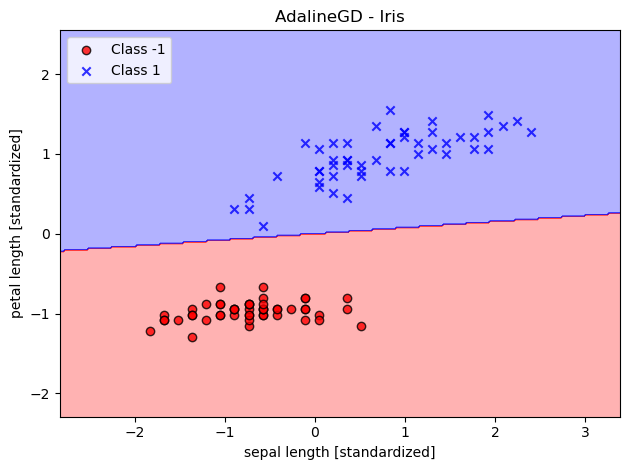

(75816, 2)


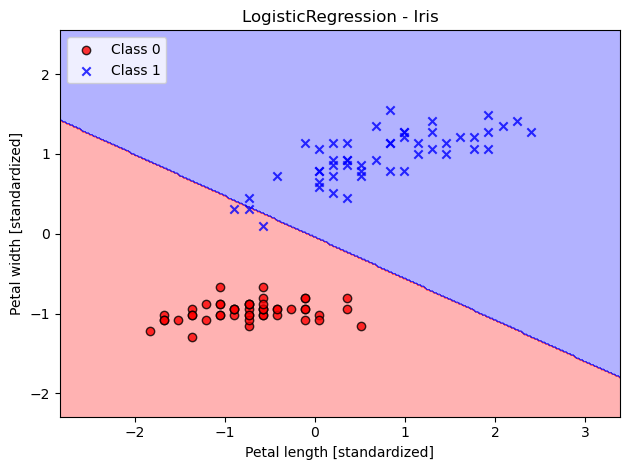

In [10]:
ada_gd = AdalineGD(n_iter=NUM_ITER, eta=ETA)
ada_gd.fit(X_std1_ada, y1_ada)

plot_decision_regions(X_std1_ada, y1_ada, classifier=ada_gd)
plt.title('AdalineGD - Iris')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

lrgd = LogisticRegression(eta=ETA,
                             n_iter=NUM_ITER,
                             random_state=1)
lrgd.fit(X_std1, y1)
plot_decision_regions(X_std1, y1, classifier=lrgd)

plt.title('LogisticRegression - Iris')
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

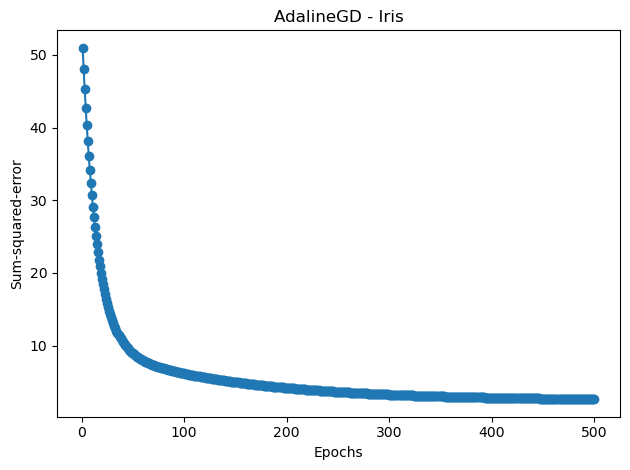

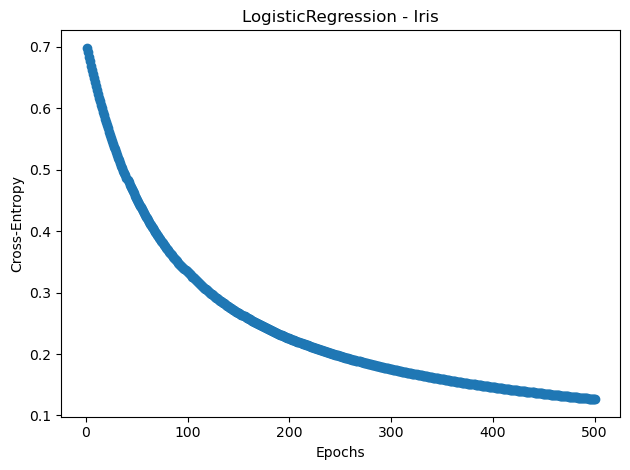

In [11]:
plt.plot(range(1, len(ada_gd.cost_) + 1),
         ada_gd.cost_, marker='o')
plt.title('AdalineGD - Iris')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(lrgd.losses_) + 1),
         lrgd.losses_, marker='o')
plt.title('LogisticRegression - Iris')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.tight_layout()
plt.show()

(93536, 2)


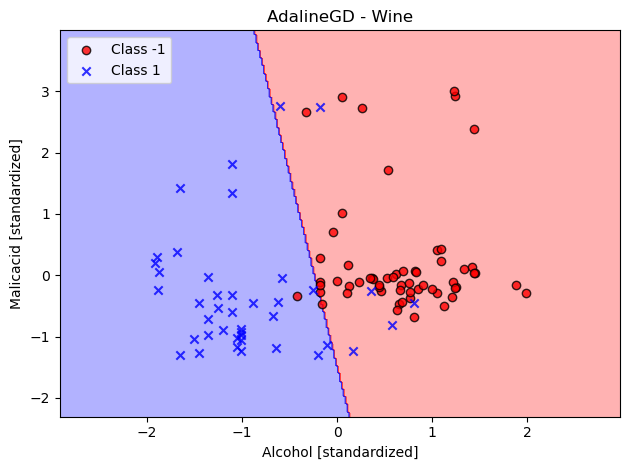

(93536, 2)


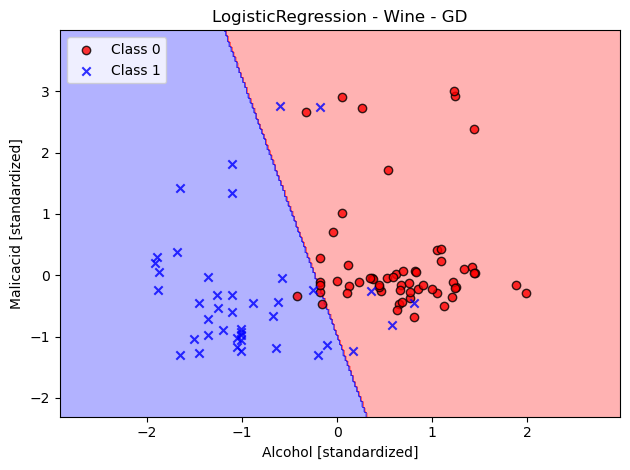

In [12]:
ada_gd2 = AdalineGD(n_iter=NUM_ITER, eta=ETA)
ada_gd2.fit(X_std2_ada, y2_ada)

plot_decision_regions(X_std2_ada, y2_ada, classifier=ada_gd2)
plt.title('AdalineGD - Wine')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

lrgd2 = LogisticRegression(eta=ETA,
                             n_iter=NUM_ITER,
                             random_state=1)
lrgd2.fit(X_std2, y2)
plot_decision_regions(X_std2, y2, classifier=lrgd2)

plt.title('LogisticRegression - Wine - GD')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

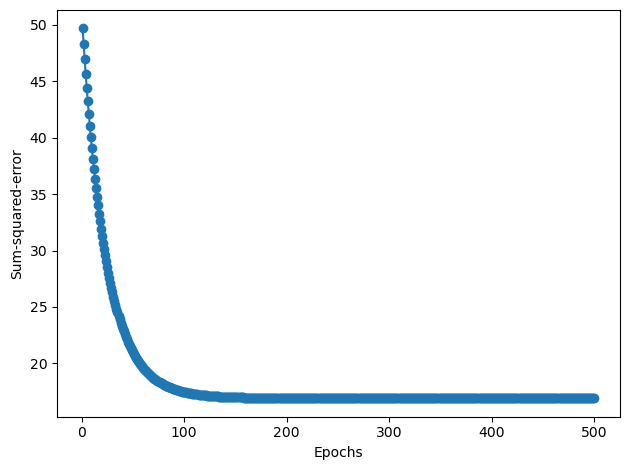

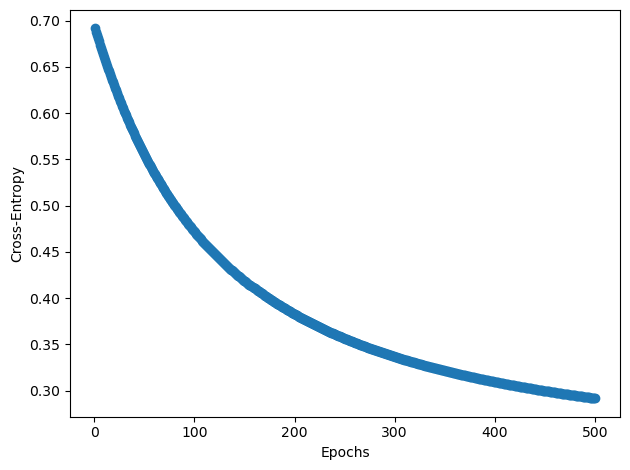

In [13]:
plt.plot(range(1, len(ada_gd2.cost_) + 1),
         ada_gd2.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(lrgd2.losses_) + 1),
         lrgd2.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.tight_layout()
plt.show()

# ANSWER 1 WOULD GO HERE

# Problem 2
Compare the performance of Adaline and logistic regression (bias absorbed versions) on the Iris
and Wine datasets that can be obtained from the UCI machine learning repository. You may use the Python
program given in our textbook (Page 117) to import the datasets.
- Iris dataset - You may consider the samples with the labels setosa, versicolor to form a training set for binary classification.
- Wine dataset - You may consider the samples with in the first two classes (1 and 2) to form a training set for binary classification.

The comparisons should be done based on the convergence of the loss. In order to make apple-to-apple comparisons, you should use the same hyperparameters and number of epochs for both learning algorithms.

# ANSWER 2 WOULD GO HERE

# Problem 3

In [18]:
import numpy as np

class Perceptron:
    """
    Docstring for Perceptron

    Hyperparameters:
    eta: a float representing the learning rate. 

    n_iter: Number of epochs to run through. 

    random_state: An integer used as the seed for the 
    random state generator. Initializes small values for
    best performance to prevent overcorrecting. 
    
    If all weights were 0, all will have the same error. 
    "Broken symmetry" allows for algorithm to work. 

    Attributes:
    Indicated with a _ afterwards as part of naming convention (how?
    to what end?)

    w_: vector of weights as a 1D array.

    b_: Scalar int, bias unit. 

    errors_: a list 
    Number of misclassifications in each epoch. 
    """
    def __init__(self, eta = 0.01, n_iter = 50, random_state = 1):

        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        """
        Fitting Training Data
        Params:
        X {array-like}, shape = [n_examples, n_features]
        Training vectors, where n_examples is the number of examples and n_features is the number of features.
        y (array-like) ,shape = [n_examples]
        Target values.

        Returns:
        self : Object
        """
        m = X.shape[1] #number of features in dataset
        rand_gen = np.random.RandomState(self.random_state)
        self.w_ = rand_gen.normal(loc=0.0, scale=0.01,
                                  size=1 + m) #small random numbers
                                              #drawn from a normal distrib.
                                              #with std dev 0.01
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0 
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update #w_[0] is the bias
                errors+= int(update != 0.0)
            self.errors_.append(errors)
        return self
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [19]:
"""
Docstring for multiclass

This implementation uses a one-vs-many approach, where different perceptrons are used. 
- One perceptron per iris class
- Modify true outputs such that the correct species is 1 and the two incorrect species are 0. 
- 

"""

class Multiclass():
    """
    Docstring for MultiPerceptron
    """

    def __init__(self):
        self.setosa_neuron = Perceptron(n_iter=NUM_ITER)
        self.versicolor_neuron = Perceptron(n_iter=NUM_ITER)
        self.virginica_neuron = Perceptron(n_iter=NUM_ITER)
    def fit(self, X, y):
        self.setosa_neuron.fit(X,np.where(y == 0,  1, -1))
        self.versicolor_neuron.fit(X,np.where(y == 1,  1, -1))
        self.virginica_neuron.fit(X,np.where(y == 2,  1, -1))
        return self
    def predict(self, X):
        c = np.column_stack([self.setosa_neuron.predict(X),
                             self.versicolor_neuron.predict(X),
                             self.virginica_neuron.predict(X)])

        predicted = np.zeros(X.shape[0])
        for i in (range(X.shape[0])):
            best_value = c[i,0]
            best_label = 0
            for j in (range(c.shape[1])):
                if c[i,j] > best_value:
                    best_value = c[i,j]
                    best_label = j
            predicted[i]= best_label
        return predicted

In [20]:
mc = Multiclass()

# read data from data file
data = pd.read_csv("data/iris.data", header=None, encoding='utf-8') 

# find feature matrix and true class labels from data
X_4 = data.iloc[:, [2, 3]].to_numpy()
Y_ref = data.iloc[:, 4].to_numpy()

Y_ref = np.where(Y_ref == 'Iris-setosa',0,Y_ref)
Y_ref = np.where(Y_ref == 'Iris-versicolor',1,Y_ref)
Y_ref = np.where(Y_ref == 'Iris-virginica',2,Y_ref)

In [21]:
X_std4 = np.copy(X_4)
X_std4[:,0] = (X_4[:,0] - X_4[:,0].mean()) / X_4[:,0].std()
X_std4[:,1] = (X_4[:,1] - X_4[:,1].mean()) / X_4[:,1].std()

(69144, 2)


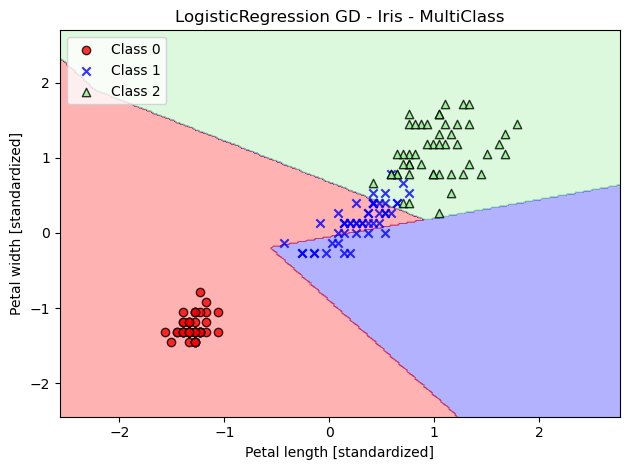

In [22]:
mc.fit(X_std4, Y_ref)
plot_decision_regions(X_std4, Y_ref, classifier=mc)

plt.title('LogisticRegression GD - Iris - MultiClass')
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Answer 3 goes here...

# Problem 4

(93536, 2)


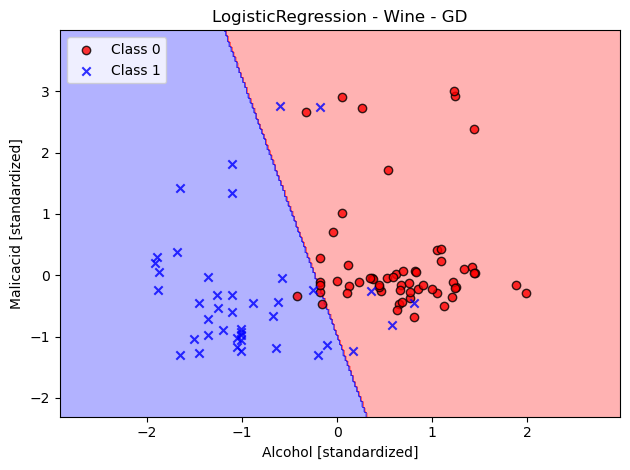

(93536, 2)


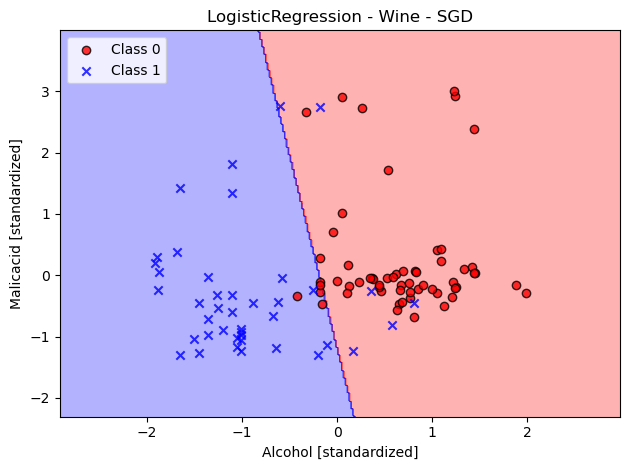

(93536, 2)


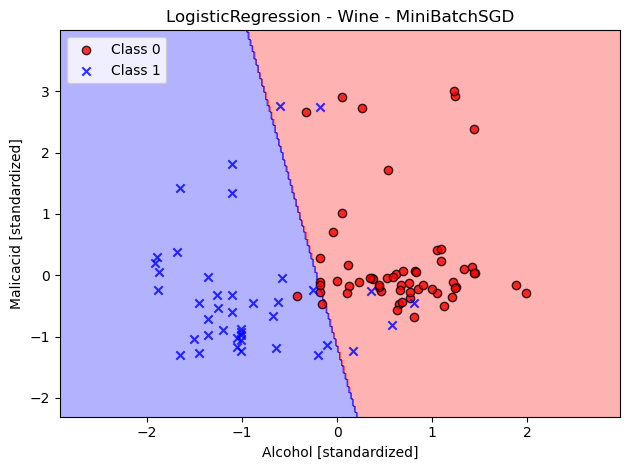

In [25]:
plot_decision_regions(X_std2, y2, classifier=lrgd2)
plt.title('LogisticRegression - Wine - GD')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

lr_sgd = LogisticRegression(eta=ETA, 
                              n_iter =NUM_ITER,
                              batch_size=1,
                              shuffle=True)
lr_sgd.sgd_fit(X_std2, y2)
plot_decision_regions(X_std2, y2, classifier=lr_sgd)
plt.title('LogisticRegression - Wine - SGD')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

minibatchSGD = LogisticRegression(eta=ETA, 
                                  n_iter=NUM_ITER, 
                                  batch_size=32,
                                  shuffle=True)
minibatchSGD.fit_mini_batch_SGD(X_std2, y2)
plot_decision_regions(X_std2, y2, classifier=minibatchSGD)

plt.title('LogisticRegression - Wine - MiniBatchSGD')
plt.xlabel('Alcohol [standardized]')
plt.ylabel('Malicacid [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

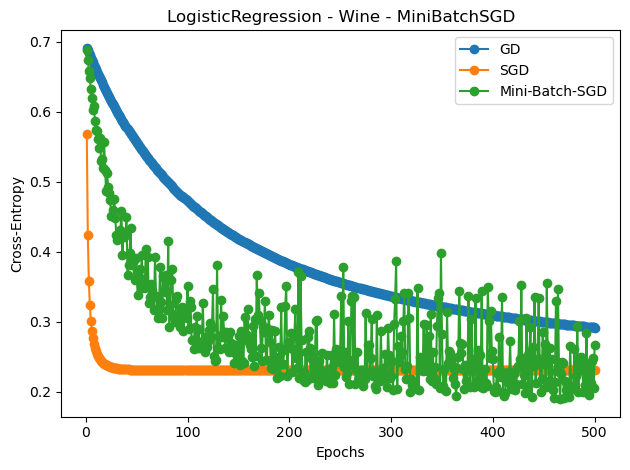

In [26]:
plt.plot(range(1, len(lrgd2.losses_) + 1),
         lrgd2.losses_, marker='o')
plt.plot(range(1, len(lr_sgd.losses_) + 1),
         lr_sgd.losses_, marker='o')
plt.plot(range(1, len(minibatchSGD.losses_) + 1),
         minibatchSGD.losses_, marker='o')
plt.title('LogisticRegression - Wine - MiniBatchSGD')
plt.legend(['GD','SGD','Mini-Batch-SGD'])
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.tight_layout()
plt.show()

Answer 4 goes here...